### Prepare Workspace

In [1]:
# Import system libraries
import os
import sys

# Import data cleaning libraries
import pandas as pd
import numpy as np
import calendar
from datetime import datetime

# Import machine learning libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV
import shap

# Import data visualisation libraries
import matplotlib.pyplot as plt 

# Import warning libraries
import warnings
warnings.filterwarnings("ignore")

# Set working directory
os.chdir('/Users/jessicarapson/Documents/GitHub/crop-yield-estimate/')
sys.path.insert(0, '/Users/jessicarapson/Documents/GitHub/crop-yield-estimate/pipeline')

# Import preprocessing libraries
from preprocessing import cleaning
from preprocessing import feature_engineering
from preprocessing import scaling
from preprocessing import feature_selection
from preprocessing import dim_reduction
from preprocessing import clustering

# Preprocess data
train_path = "data/Train.csv"
test_path = "data/Test.csv"
df = cleaning.clean_data(train_path, test_path)
df = feature_engineering.get_features(df)
df = scaling.scale_features(df)
df = feature_selection.select_features(df)
df = dim_reduction.reduce_dim(df)
df = clustering.get_clusters(df)

# Split data into training and test sets
df_train = df[df['Yield'].isna() == False]
df_test = df[df['Yield'].isna() == True]

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### Build Yield Generic Yield Per Acre Model

Root Mean Squared Error: 134.0954740295029


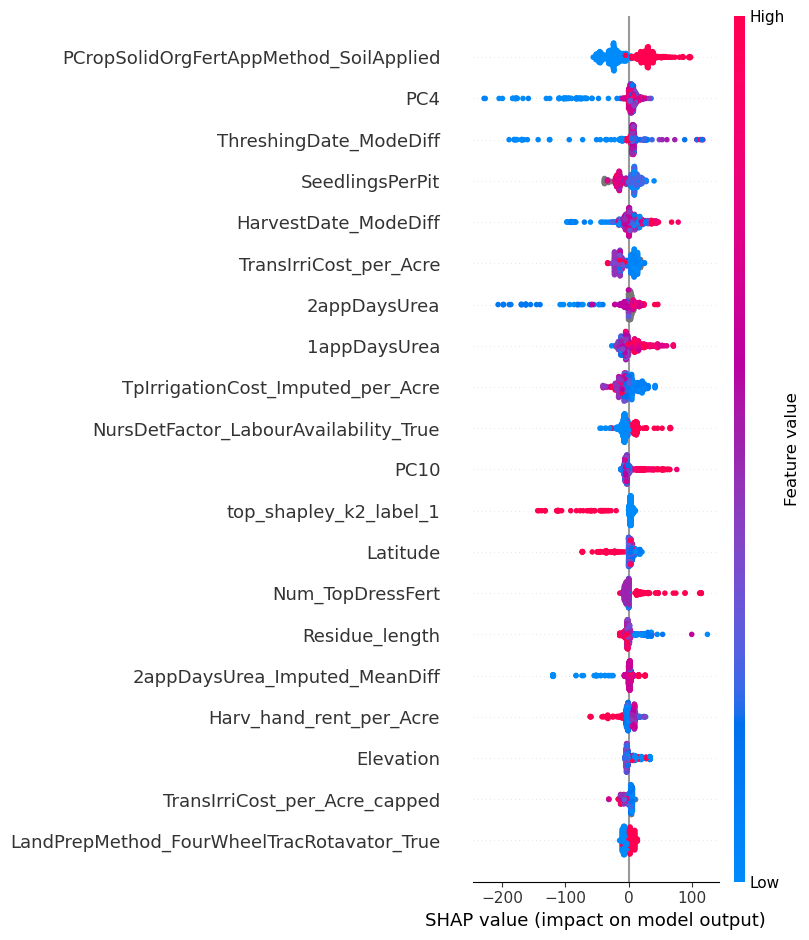

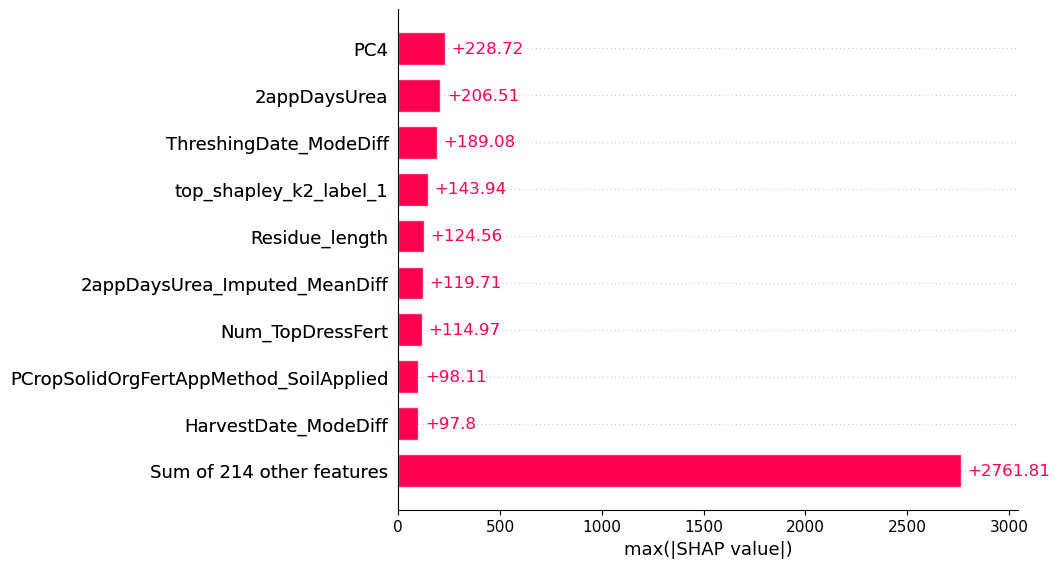

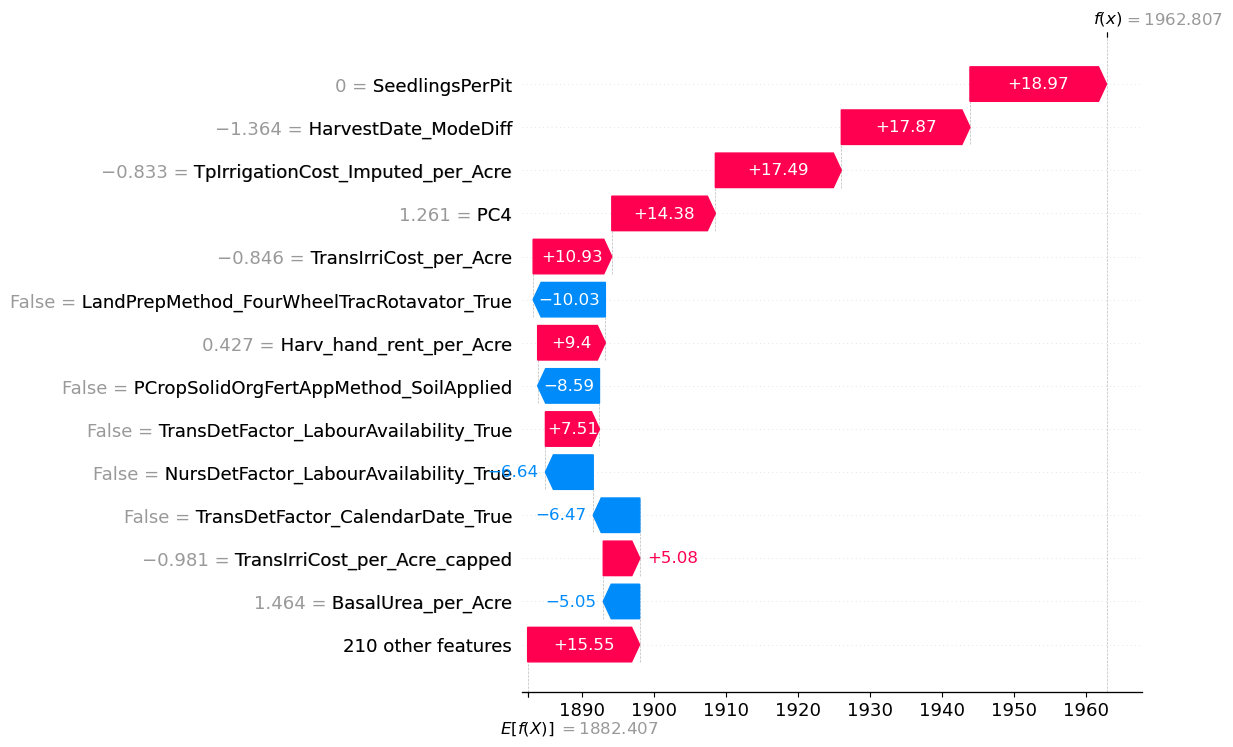

In [2]:
# Split data
outcome_cols = ["Yield","Yield_per_Acre","New_Yield","New_Yield_per_Acre"]
X, y = df_train.drop(outcome_cols, axis=1), df_train["New_Yield_per_Acre"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate an XGBoost regressor model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3,
                          learning_rate = 0.1, max_depth = 5, alpha = 10,
                          n_estimators = 10)

# Train the XGBoost model
xg_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = xg_reg.predict(X_test)

# Evaluate the model using RMSE (Root Mean Squared Error)
indices = list(y_test.index)
rmse = mean_squared_error(df_train.loc[indices]["New_Yield"],
                          y_pred * df_train.loc[indices]["Acre"], squared=False)
print("Root Mean Squared Error:", rmse)

# # Define the number of folds for cross-validation
# num_folds = 20

# # Split data into two folds
# fold_size = len(X) // num_folds
# for i in range(num_folds):
#     # Define the training and testing indices for this fold
#     test_indices = list(range(i * fold_size, (i + 1) * fold_size))
#     train_indices = [idx for idx in range(len(X)) if idx not in test_indices]

#     # Split the data into training and testing sets for this fold
#     X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
#     y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    
# # Train your model on the training set
# xg_reg.fit(X_train, y_train)

# # Predict on the test set
# y_pred = xg_reg.predict(X_test)

# # Calculate and print the evaluation metric (e.g., RMSE)
# rmse = mean_squared_error(y_test, y_pred, squared=False)
# print(f"Fold {i+1} RMSE: {rmse}")

# Create a TreeExplainer object with the XGBoost model
explainer = shap.TreeExplainer(xg_reg)

# Calculate Shapley values for a specific sample (replace index with your desired sample index)
shap_values = explainer.shap_values(X_test)

# Summary plot of Shapleys values
shap.summary_plot(shap_values, X_test)
shap.plots.bar(explainer(X_test).abs.max(0))

# Explain one specific prediction
sample_index = 21
shap_values = explainer(X)
shap.plots.waterfall(shap_values[sample_index], max_display=14)

### Make Predictions

In [3]:
# Retrain model on entire training data
xg_reg.fit(X, y)
print("---Training complete---")

---Training complete---


In [4]:
# Make predictions
test_predictors = df_test.drop(outcome_cols, axis=1)
test_pred = xg_reg.predict(test_predictors) * df_test["Acre"]

# Add predictions to sample submission file
df_test_pred = pd.read_csv("data/SampleSubmission.csv")
df_test_pred['Yield'] = test_pred
df_test_pred['Yield'] = np.where(df_test_pred['ID'] == 'ID_PMSOXFT4FYDW',
                                 df_test_pred['Yield'] * 10, df_test_pred['Yield'])

# Export submission
df_test_pred.to_csv('submission/Submission.csv', index=False)

print("---Predictions made---")

---Predictions made---


### Test Ideas

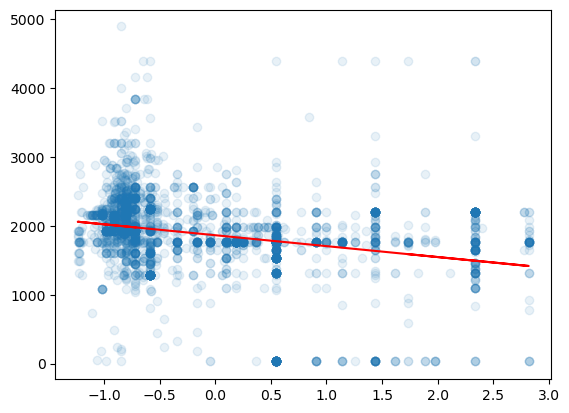

In [43]:
var = 'TransIrriCost_per_Acre_capped'

data = df_train[df_train[var].isna() == False]
slope, intercept = np.polyfit(data[var], data['New_Yield_per_Acre'], 1)

# Plot the line of best fit
plt.plot(data[var], slope * data[var] + intercept, color='red') 
plt.scatter(data[var], data['New_Yield_per_Acre'], alpha=0.1)

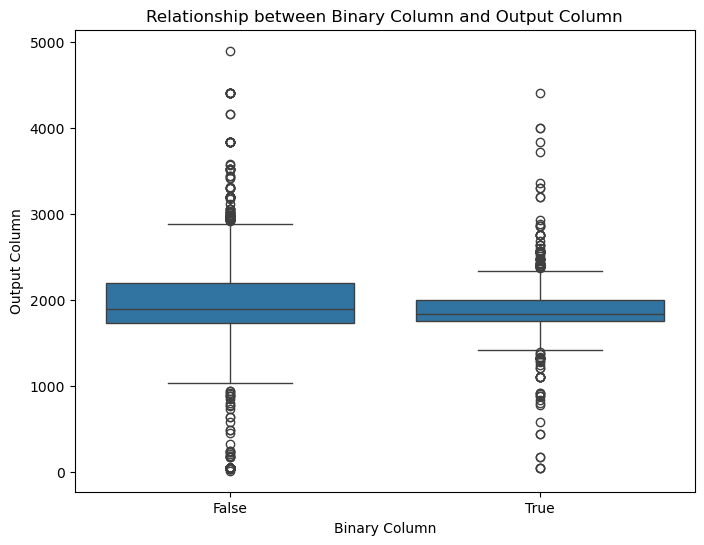

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a boxplot to visualize the relationship
plt.figure(figsize=(8, 6))
sns.boxplot(x='1appDaysUrea_NaN_True', y='New_Yield_per_Acre', data=df)
plt.xlabel('Binary Column')
plt.ylabel('Output Column')
plt.title('Relationship between Binary Column and Output Column')
plt.show()

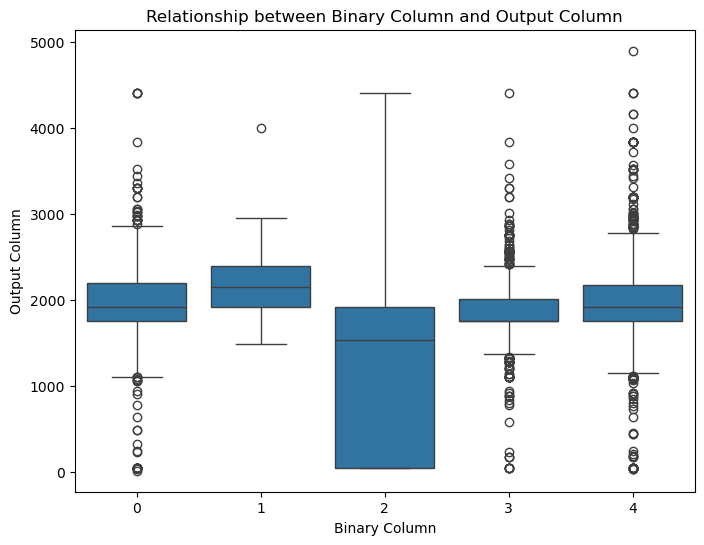

6.892366255342163e-147
Reject null hypothesis: There is a significant difference between groups.


In [181]:
col = 'k5_label'
data = df[df['New_Yield_per_Acre'].isna() == False]

# Create a boxplot to visualize the relationship
plt.figure(figsize=(8, 6))
sns.boxplot(x=col, y='New_Yield_per_Acre', data=df)
plt.xlabel('Binary Column')
plt.ylabel('Output Column')
plt.title('Relationship between Binary Column and Output Column')
plt.show()

from scipy.stats import f_oneway

# Assuming 'group_column' is your integer group column and 'outcome_column' is your float outcome column
group1 = data['New_Yield_per_Acre'][data[col] == 0]
group2 = data['New_Yield_per_Acre'][data[col] == 1]
group3 = data['New_Yield_per_Acre'][data[col] == 2]
group4 = data['New_Yield_per_Acre'][data[col] == 3]
group5 = data['New_Yield_per_Acre'][data['k5_label'] == 4]
# ... add more groups as needed

# Perform ANOVA test
f_statistic, p_value = f_oneway(group1, group2, group3, group4, group5)  # Add more groups as needed

# Check the significance
alpha = 0.05
print(p_value)
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference between groups.")
else:
    print("Fail to reject null hypothesis: There is no significant difference between groups.")

In [5]:
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(X)
top_columns = []

# Calculate the maximum absolute value of each column in the shap_values matrix
column_max_abs = np.max(np.abs(shap_values), axis=0)

# Attach maximum absolute values to column names
column_max_with_names_abs = {column: max_val for column, max_val in zip(X.columns, column_max_abs)}

# Sort the column maximum absolute values in descending order
sorted_column_max_abs = sorted(column_max_with_names_abs.items(), key=lambda x: x[1], reverse=True)

# Save all column names into a sorted array
sorted_columns = [column for column, _ in sorted_column_max_abs]

# Display top N column names with their maximum absolute values in descending order
for column, max_val in sorted_column_max_abs:
    top_columns.append(column)
    
top_cols = top_columns[:60]

# Calculate mean of each column in the shap_values matrix
column_means = np.mean(shap_values, axis=0)

# Attach mean values to column names
column_means_with_names = {column: mean for column, mean in zip(X.columns, column_means)}

# # Display column names with their mean values
# for column, mean in column_means_with_names.items():
#     print(f"{column}: {mean}")
    
# print(top_cols)

In [6]:
# Run Shaw's code


# Split data
outcome_cols = ["Yield","Yield_per_Acre","New_Yield","New_Yield_per_Acre"]

# Drop columns excluding the top features
X, y = df_train.drop(outcome_cols, axis=1), df_train["New_Yield_per_Acre"]

X = X[top_cols]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [10, 50, 100]
}

# Instantiate an XGBoost regressor model
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best parameters and best score from grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Train the XGBoost model with the best parameters
xg_reg_best = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, **best_params)
xg_reg_best.fit(X_train, y_train)

# Predict on the test set using the best model
y_pred_best = xg_reg_best.predict(X_test)


indices = list(y_test.index)


# Evaluate the best model using RMSE (Root Mean Squared Error)
rmse_best = mean_squared_error(df_train.loc[indices]["New_Yield"], y_pred_best * df_train.loc[indices]["Acre"], squared=False)
print("Best Model - Root Mean Squared Error:", rmse_best)


Best Model - Root Mean Squared Error: 113.5822488184597


In [7]:
# Train the XGBoost model with the best parameters on all the data
xg_reg_best = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, **best_params)
xg_reg_best.fit(X, y)
print("---Training complete---")

# Make predictions
test_predictors = df_test.drop(outcome_cols, axis=1)[top_cols]
test_pred = xg_reg_best.predict(test_predictors) * df_test["Acre"]

# Add predictions to sample submission file
df_test_pred = pd.read_csv("data/SampleSubmission.csv")
df_test_pred['Yield'] = test_pred
df_test_pred['Yield'] = np.where(df_test_pred['ID'] == 'ID_PMSOXFT4FYDW',
                                 df_test_pred['Yield'] * 10, df_test_pred['Yield'])

# Export submission
df_test_pred.to_csv('submission/Submission.csv', index=False)

print("---Predictions made---")

---Training complete---
---Predictions made---


In [12]:
# Predict on the test set using the best model
y_pred_best = xg_reg_best.predict(X)
mean_squared_error(df_train["New_Yield"], y_pred_best * df_train["Acre"], squared=False)

46.267890109130946

In [68]:
### Check whether predition is an under or over-estimate
data = X
data['Acre'] = df_train['Acre']
data['New_Yield'] = df_train['New_Yield']
data['pred'] = y_pred_best
data['true_value'] = y
data['error'] = y - y_pred_best
data['error_scaled'] = (data['error'] - data['error'].mean()) /  data['error'].std()
data['under_predict'] = data['error_scaled'] > 3

data[['pred', 'true_value', 'error']]
data['error'].describe()
data.sort_values(by='error', ascending=True)

,CultLand,CropCultLand,CropTillageDepth,SeedlingsPerPit,TransplantingIrrigationHours,TransIrriCost,StandingWater,Ganaura,CropOrgFYM,NoFertilizerAppln,...,top_shapley_k5_label_1,top_shapley_k5_label_2,top_shapley_k5_label_3,top_shapley_k5_label_4,New_Yield,pred,true_value,error,error_scaled,under_predict
2492,-0.848471,-0.778247,0.571429,0.000000,-0.167963,0.515070,0.105263,-0.146433,-0.075682,0.666667,...,False,False,False,False,600.0,4260.909668,True,-4259.909668,-4.936930,False
1693,1.934444,2.233623,0.714286,0.047619,-0.096048,-0.443788,0.157895,-0.106807,-0.101615,0.333333,...,False,False,False,True,1100.0,4138.692871,True,-4137.692871,-4.682910,False
2463,-0.848471,-0.778247,0.571429,0.047619,-0.167963,0.515070,0.105263,-0.146433,-0.075682,0.666667,...,False,False,False,False,600.0,4125.699219,True,-4124.699219,-4.655904,False
3030,-0.642329,-0.592329,0.428571,0.047619,5.117789,-0.204073,0.000000,-0.146433,-0.096429,0.666667,...,False,True,False,False,600.0,4062.941895,True,-4061.941895,-4.525467,False
555,-0.298759,-0.629512,0.428571,0.000000,-0.203921,0.035641,0.052632,-0.146433,-0.086055,0.666667,...,False,False,False,False,600.0,3956.543945,True,-3955.543945,-4.304326,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,-0.298759,-0.555145,0.571429,0.047619,-0.167963,0.515070,0.052632,-0.146433,-0.091242,0.666667,...,False,True,False,False,10.0,14.488094,True,-13.488094,3.888976,True
3011,-0.642329,-0.741063,0.571429,0.047619,5.117789,-0.204073,0.000000,-0.146433,-0.096429,0.666667,...,False,True,False,False,4.0,14.209319,True,-13.209319,3.889555,True
3809,-0.470544,-0.741063,0.571429,0.047619,5.117789,-0.204073,0.000000,-0.146433,-0.096429,0.666667,...,False,True,False,False,4.0,12.705644,True,-11.705644,3.892681,True
1426,-0.470544,-0.555145,0.571429,0.047619,-0.239878,-0.443788,0.052632,-0.146433,-0.096429,0.666667,...,False,True,False,False,4.0,9.201502,True,-8.201502,3.899964,True


In [78]:
from sklearn.metrics import accuracy_score, classification_report

# Splitting the data into train and test sets
outcome_cols = ["Yield","Yield_per_Acre","New_Yield","New_Yield_per_Acre"]
X, y = df_train.drop(outcome_cols, axis=1), data["error_scaled"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining the XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42,
                            colsample_bytree=0.3, **best_params)

# Training the XGBoost regressor
xgb_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluating the model using RMSE (Root Mean Squared Error)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

# # Defining the XGBoost classifier
# xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# # Training the XGBoost classifier
# xgb_model.fit(X_train, y_train)

# # Making predictions on the test set
# y_pred = xgb_model.predict(X_test)
# y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # Probability of positive class

# # Evaluating the model
# accuracy = accuracy_score(y_test, y_pred)
# classification_rep = classification_report(y_test, y_pred)

# print("Accuracy:", accuracy)
# print("Classification Report:")
# print(classification_rep)

Root Mean Squared Error: 0.4862694


In [89]:
(y_test - y_pred).abs().sort_values(ascending = False)

3030    7.791913
929     3.274818
3367    2.786722
2396    2.760220
3683    1.979379
          ...   
211     0.001597
2694    0.001232
2571    0.000454
3391    0.000255
1330    0.000233
Name: error_scaled, Length: 774, dtype: float32

In [81]:
y_pred

array([-9.73463476e-01, -1.45470548e+00,  2.87228860e-02,  7.59732872e-02,
        1.08273542e+00,  4.86975670e-01, -1.62664562e-01, -6.42186105e-01,
       -7.78866336e-02,  2.17861429e-01, -4.21651229e-02,  2.87048072e-01,
        3.30386013e-02, -6.45490110e-01, -6.71687484e-01,  3.71299565e-01,
       -4.89056706e-01,  3.22025776e-01, -4.20517951e-01, -7.88723409e-01,
        5.24041317e-02, -8.88282955e-01,  3.64813018e+00,  4.83502001e-01,
        8.24366063e-02,  5.84853232e-01,  2.10343778e-01, -9.06306088e-01,
       -3.50297660e-01,  1.88706830e-01,  2.73536623e-01, -3.88502419e-01,
        1.48137197e-01,  5.34687281e-01,  1.52435929e-01, -8.13441277e-01,
       -5.52866042e-01, -2.88927823e-01,  2.43311971e-01,  5.22293687e-01,
       -5.28620481e-01, -6.85463846e-01, -1.31066024e+00, -3.60670000e-01,
       -3.86318874e+00, -6.71529830e-01, -8.06220889e-01, -1.54415667e+00,
        3.60637951e+00,  2.52924040e-02, -2.68545777e-01, -3.15628886e-01,
        1.76525921e-01,  

In [39]:
# Create regression model to predict how much model will get the result wrong

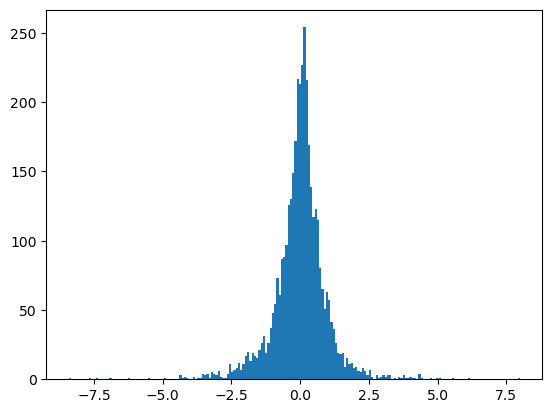

In [14]:
plt.hist(X['error_scaled'], bins=200)
plt.show()

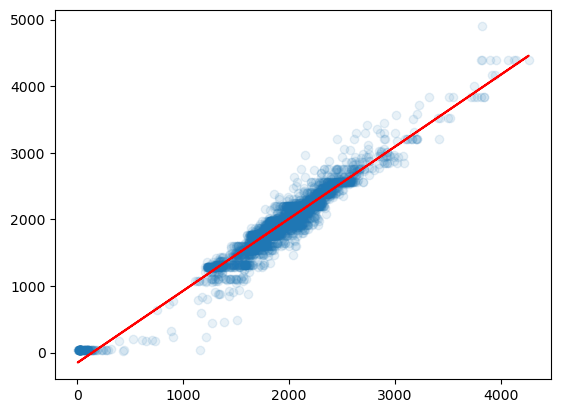

In [15]:
var = 'pred'
slope, intercept = np.polyfit(X[var], X['true_value'], 1)

# Plot the line of best fit
plt.plot(X[var], slope * X[var] + intercept, color='red') 
plt.scatter(X[var], X['true_value'], alpha=0.1)

In [91]:
df_train.iloc[3030]

CultLand                       -0.642329
CropCultLand                   -0.592329
CropTillageDepth                0.428571
SeedlingsPerPit                 0.047619
TransplantingIrrigationHours    5.117789
                                  ...   
top_shapley_k4_label_3             False
top_shapley_k5_label_1             False
top_shapley_k5_label_2              True
top_shapley_k5_label_3             False
top_shapley_k5_label_4             False
Name: 3030, Length: 227, dtype: object

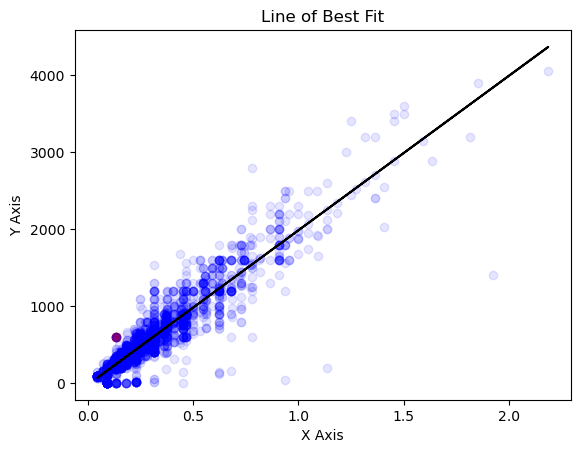

In [99]:
# Perform linear regression
slope, intercept = np.polyfit(df_train['Acre'], df_train['New_Yield'], 1)

# Plot data points with different colors based on 'Category'
cutoff = -2
#plt.scatter(X[X['error_scaled']>=cutoff]['Acre'], X[X['error_scaled']>=cutoff]['New_Yield'], color='blue')
#plt.scatter(X[X['error_scaled']<cutoff]['Acre'], X[X['error_scaled']<cutoff]['New_Yield'], color='red')
plt.scatter(df_train.iloc[3030]['Acre'], df_train.iloc[3030]['New_Yield'], color = 'red')
plt.scatter(df_train['Acre'], df_train['New_Yield'], color='blue', alpha = 0.1)


# Plot the line of best fit
plt.plot(df_train['Acre'], slope * df_train['Acre'] + intercept, color='black')  # y = mx + c

plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Line of Best Fit')
plt.show()

In [31]:
### Add prediction for degree of under or over-estimate

In [ ]:
### Plot yield per acre outliers and develop model that oversamples under-preforming yield

In [ ]:
### Add mean encoding